In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D,Conv1DTranspose
from keras.layers.convolutional import MaxPooling1D
from keras.layers import LSTM, Bidirectional,ConvLSTM1D
from keras.layers import TimeDistributed,GaussianNoise
from keras.layers import RepeatVector
from keras.layers import Input

from keras.layers import BatchNormalization
from keras.preprocessing.image import img_to_array, array_to_img
from keras.preprocessing.image import load_img
import numpy as np
from numpy import genfromtxt
import cv2
from sklearn.model_selection import train_test_split
from scipy.integrate import odeint
from sklearn.preprocessing import MinMaxScaler


physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from scipy.interpolate import CubicSpline

#shuffler
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]


def scalerThetis(x, xmin, xmax, min, max):
    scale = (max - min)/(xmax - xmin)
    xScaled = scale*x + min - xmin*scale
    return xScaled

def inverseScalerThetis(xscaled, xmin, xmax, min, max):
    scale = (max - min) / (xmax - xmin)
    xInv = (xscaled/scale) - (min/scale) + xmin
    return xInv

    
X_Dat=[]



data_size=173
num_states=5
num_days=3



X_omeg=[]
differential=3


for i in range(data_size): 
  daty = genfromtxt("D:\Research_work\My_covid_research\dataset_preprocessing\parameter_estim\input\states_ "+str(i+1)+" .csv", delimiter=',')
  X_omeg.append(daty[:,1:])


X_omeg=np.array(X_omeg)
X_omeg=X_omeg.reshape(data_size*num_days,num_states)


X=X_omeg[0:-differential,:]
Y=X_omeg[differential:,:]

scaler = MinMaxScaler()
X=scaler.fit_transform(X)
scaler2 = MinMaxScaler()
Y=scaler2.fit_transform(Y)

X=X.reshape(int(len(X)/differential),3,5)
Y=Y.reshape(int(len(Y)/differential),3,5)

# X=scalerThetis(X,np.min(X,axis=0),np.max(X,axis=0),-1,1)
# Y=scalerThetis(Y,np.min(Y,axis=0),np.max(Y,axis=0),-1,1)
print(X.shape, Y.shape)  
# print(X_train.shape, y_train.shape)
# print(X_valid.shape, y_valid.shape)
# print(X_test.shape, y_test.shape)


(172, 3, 5) (172, 3, 5)


Text(0.5, 1.0, 'Training and validation loss')

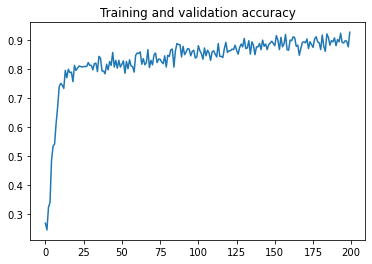

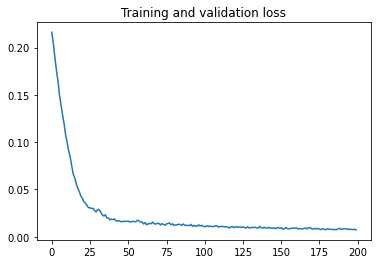

In [4]:
look_backY=differential

input_shape = X.shape[1:]
input_lstm = keras.Input(shape=input_shape)
lstm_1 = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(input_lstm)
dropout_1 = layers.Dropout(0.5)(lstm_1)
bn_1 = layers.BatchNormalization()(lstm_1)
rv_1 = layers.RepeatVector(look_backY)(dropout_1)
dense_1 = layers.TimeDistributed(layers.Dense(X.shape[2], activation='linear'))(rv_1)
lstm_model = keras.Model(input_lstm, dense_1)


optimizer = keras.optimizers.Adam(learning_rate=0.001)
lstm_model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

history=lstm_model.fit(X,Y , batch_size=64*4,verbose=0, epochs=200)
#---------------------------------------------------------------------------------------------
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


acc = history.history['accuracy']


loss = history.history['loss']


epochs = range(len(acc))

plt.plot(epochs, acc)
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss)
plt.title('Training and validation loss')

In [5]:
from sklearn.metrics import mean_absolute_error

hor=5
X_omeg=[]

for i in range(hor): 
  daty = genfromtxt("D:\Research_work\My_covid_research\dataset_preprocessing\parameter_estim\input_new\states_ "+str(i)+" .csv", delimiter=',')
  X_omeg.append(daty[:,1:])

X_omeg=np.array(X_omeg)
interlude=X_omeg.reshape(hor*3,num_states)
sub_X=scaler.transform(interlude)
sub_X=sub_X.reshape(hor,3,5)

rec=[]
for i in range(hor-1):
  if i==0:
    rec.append(sub_X[0:1,:,:])
    y=lstm_model.predict(sub_X[0:1,:,:])
    rec.append(y)
  else:
    y=lstm_model.predict(rec[-1])
    rec.append(y)

rec=np.array(rec)
rec=rec.reshape(hor,3,5)
# rec=inverseScalerThetis(rec,np.min(rec,axis=0),np.max(rec,axis=0),-1,1)
X_pred=rec.reshape(hor*3,5)
X_pred=scaler2.inverse_transform(X_pred)
X_ref=X_omeg.reshape(hor*3,5)

print("MAE:", mean_absolute_error(X_ref, X_pred))

MAE: 220.69380976354591


In [6]:
from sklearn.metrics import mean_squared_error
rms = mean_squared_error(X_ref, X_pred, squared=False)
print("RMSE:", rms)


RMSE: 320.43030279216333


In [7]:
import pandas as pd
S=X_pred[:,0]
I=X_pred[:,1]
Q=X_pred[:,2]
R=X_pred[:,3]
D=X_pred[:,4]


dataset = pd.DataFrame({'S': S, 'I': I, 'Q': Q, 'R': R, 'D': D})
dataset.to_csv('bilstm_korea.csv', index=False)